#### DSC530-302 Data Exploration and Analysis
##### Author: Chitramoy Mukherjee
##### Date: 05/25/2023
##### Title: "DSC530-302 Week-11 Assignment- 13.1"

In [ ]:
In NSFG Cycles 6 and 7, the variable cmdivorcx contains the date of divorce for the respondent’s first marriage, 
if applicable, encoded in century-months. Compute the duration of marriages that have ended in divorce, and the duration,
so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.
Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.
Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [5]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/1995FemRespData.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz")
import thinkstats2
import thinkplot
import numpy as np
import pandas as pd
import nsfg
import survival
import warnings

In [2]:
# Define CleanData to Clean respondent data.
def CleanData(resp):
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [6]:
resp6 = nsfg.ReadFemResp()
resp6.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp6["agemarry"] = (resp6.cmmarrhx - resp6.cmbirth) / 12.0
resp6["age"] = (resp6.cmintvw - resp6.cmbirth) / 12.0

resp7 = survival.ReadFemResp2010()

In [7]:
CleanData(resp6)
married6 = resp6[resp6.evrmarry == 1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry == 1]

In [8]:
# Define ResampleDivorceCurve to Plot divorce curves based on resampled data.
def ResampleDivorceCurve(resps):
    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color="#225EA8", alpha=0.1)

    thinkplot.Show(xlabel="years", axis=[0, 28, 0, 1])

In [9]:
# Define ResampleDivorceCurveByDecade to Plot divorce curves for each birth cohort.
def ResampleDivorceCurveByDecade(resps):

    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel="Years", ylabel="Fraction undivorced", axis=[0, 28, 0, 1])

In [10]:
# Define EstimateSurvivalByDecade to Groups respondents by decade and plots survival curves.
def EstimateSurvivalByDecade(groups, **options):
     thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

In [11]:
# Define EstimateSurvival to estimate the survival curve.

def EstimateSurvival(resp):
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

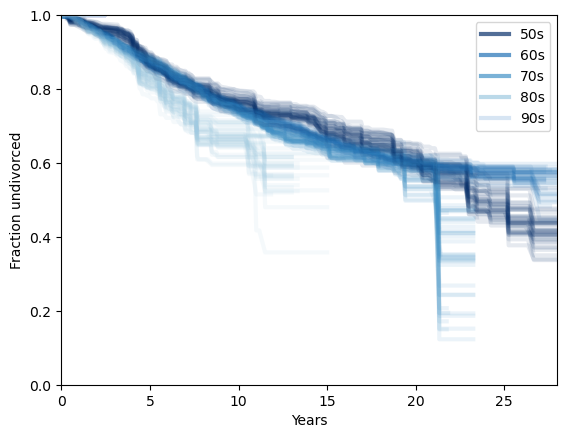

In [13]:
# Solution
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
ResampleDivorceCurveByDecade([married6, married7])
